In [10]:
## For non-negative Delta and t, set
## 	Q(B; Delta, t) = [(1/2 - Delta)^B + (1/2 + Delta)^B]*(1 + t)^{-B+1}
## The following function finds the smallest B for a given t such that
##	Q(B; Delta, t) <= alpha.
solve_for_B <- function(alpha, Delta, t){
  if(Delta == 0.5 && t == 0){
    stop("Delta is 0.5 and t = 0. The estimator lies only on one side of the parameter!")
  }
	B_low <- max(floor(log((2 + 2*t)/alpha, base = 2 + 2*t)), floor(log((1 + t)/alpha, base = (2 + 2*t)/(1 + 2*Delta))))
	B_up <- ceiling(log((2 + 2*t)/alpha, base = (2 + 2*t)/(1 + 2*Delta)))
	Q <- function(B){
		((1/2 - Delta)^B + (1/2 + Delta)^B)*(1 + t)^(-B + 1)
	}
	for(B in B_low:B_up){
		if(Q(B) <= alpha)
			break
	}
	return(B)
}

## For any estimation function estimate() that returns a
## univariate estimator, subsamp_median_bias() provides an
## estimate of the median bias using subsampling.
## The subsample size used is (sample size)^{subsamp_exp}.
## The input data is a data frame or a matrix.
## nsub is the number of subsamples
subsamp_median_bias <- function(data, estimate, subsamp_exp = 2/3, nsub = 1000){
	data <- as.matrix(data)
	nn <- nrow(data)
	subsamp_size <- round(nn^subsamp_exp)
	nsub <- min(nsub, choose(nn, subsamp_size))
	fulldata_estimate <- estimate(data)
	Delta <- 0
	for(b in 1:nsub){
		TMP <- estimate(data[sample(nn, subsamp_size, replace = FALSE),,drop=FALSE])
		Delta <- Delta + (TMP - fulldata_estimate <= 0)/nsub
	}
	Delta <- abs(Delta - 1/2)
	return(Delta)
}

## HulC1d() uses asymptotic median bias value to construct
## 		convex hull confidence interval for a univariate 
##		parameter. This is Algorithm 1 of the paper.
## data is a data frame.
## estimate is a function that takes a data frame as input 
## 		and returns a one-dimensional estimate.
## alpha is the level.
## Delta is the median bias of the estimate(). 
## randomize is a logical. If TRUE then the number of splits
## 		is randomized. If FALSE, then the larger number of
##		splits is used.
HulC1d <- function(data, estimate, alpha = 0.05, Delta = 0, randomize = TRUE){
	data <- as.matrix(data)
	nn <- nrow(data)
	data <- data[sample(nn),,drop=FALSE]
	B1 <- solve_for_B(alpha = alpha, Delta = Delta, t = 0)
	B <- B1
	if(randomize){
		p1 <- (1/2 + Delta)^B1 + (1/2 - Delta)^B1
		B0 <- B1 - 1
		p0 <- (1/2 + Delta)^B0 + (1/2 - Delta)^B0
		U <- runif(1)
		tau <- (alpha - p1)/(p0 - p1)
		B <- B0*(U <= tau)+ B1*(U > tau)
	}
	if(B > nn){
	  print(paste0("Delta = ", Delta, ", No. of splits = ", B, ", Sample size = ", nn))
		stop("Error: not enough samples for splitting!")
	}
	ci_est <- rep(0, B)
	TMP <- split(1:nn, sort((1:nn)%%B))
	for(idx in 1:B){
		ci_est[idx] <- estimate(data[TMP[[idx]],,drop=FALSE])
	}
	CI <- range(ci_est)
	names(CI) <- c("lwr", "upr")
	ret <- list(CI = CI, median.bias = Delta, B = B)
	return(ret)
}

## HulC() uses asymptotic median bias value to construct
## 		rectangular hull confidence region. This is Algorithm 1
## 		of the paper with union bound.
## data is a data frame.
## estimate is a function that takes a data frame as input 
## 		and returns a one-dimensional estimate. If multivariate,
##  	union will be used to obtain the confidence region.
## alpha is the level.
## Delta is the median bias of the estimate(). It can be a 
## 		vector. If a scalar is given, then it will repeated to
## 		form a vector of same length as dim.
## dim is the dimension of the output of estimate().
## randomize is a logical. If TRUE then the number of splits
## 		is randomized. If FALSE, then the larger number of
##		splits is used.
HulC <- function(data, estimate, alpha = 0.05, Delta = 0, dim = 1, randomize = TRUE){
	data <- as.matrix(data)
  if(length(Delta) == 1){
    Delta <- Delta*rep(1, dim)
  }
	CI <- matrix(0, nrow = dim, ncol = 2)
	B <- rep(0, dim)
	colnames(CI) <- c("lwr", "upr")
	for(idx in 1:dim){
		foo <- function(dat){
			estimate(dat)[idx]
		}
		tryCatch(
			hulc_idx <- HulC1d(data, foo, alpha = alpha/dim, Delta = Delta[idx], randomize = randomize),
      error = function(e){
        hulc_idx <- list(CI = c(NA, NA), B = NA)
      }
    )
		CI[idx,] <- hulc_idx$CI
		B[idx] <- hulc_idx$B
	}
	ret <- list(CI = CI, median.bias = Delta, B = B)
	return(ret)
}

## Adaptive_HulC() estimates the median bias of the estimator
##		and construct the rectangular confidence region. This is 
## 		Algorithm 2 of the paper with union bound.
## data is a data frame.
## estimate is a function that takes a data frame as input 
## 		and returns a one-dimensional estimate. If multivariate,
##  	union will be used to obtain the confidence region.
## alpha is the level.
## dim is the dimension of the output of estimate().
## subsamp_exp is the exponent of sample size 
## nsub is the number of subsamples.
## randomize is a logical. If TRUE then the number of splits
## 		is randomized. If FALSE, then the larger number of
##		splits is used.
adaptive_HulC <- function(data, estimate, alpha = 0.05, dim = 1, subsamp_exp = 2/3, nsub = 1000, randomize = TRUE){
	data <- as.matrix(data)
	CI <- matrix(0, nrow = dim, ncol = 2)
	colnames(CI) <- c("lwr", "upr")
	B <- rep(0, dim)
	Delta <- rep(0, dim)
	for(idx in 1:dim){
		foo <- function(dat){
			estimate(dat)[idx]
		}
		Delta[idx] <- subsamp_median_bias(data, foo, subsamp_exp = subsamp_exp, nsub = nsub)
		tryCatch(
			hulc_idx <- HulC1d(data, foo, alpha = alpha/dim, Delta = Delta[idx], randomize = randomize),
      error = function(e){
        hulc_idx <- list(CI = c(NA, NA), B = NA)
      }
    )
		CI[idx,] <- hulc_idx$CI
		B[idx] <- hulc_idx$B		
	}
	ret <- list(CI = CI, median.bias = Delta, B = B)
	return(ret)
}

## unimodal_HulC1d() uses asymptotic median bias and unimodality to
## 		construct an inflated convex hull confidence interval for a
##		univariate parameter. This is Algorithm 3 of the paper.
## data is a data frame.
## estimate is a function that takes a data frame as input and returns
## 		a one-dimensional estimate.
## alpha is the level.
## Delta is the asymptotic median bias of the estimate().
## t is the inflation factor.
## randomize is a logical. If TRUE then the number of splits
## 		is randomized. If FALSE, then the larger number of
##		splits is used.
unimodal_HulC1d <- function(data, estimate, alpha = 0.05, Delta = 1/2, t = 0.1, randomize = TRUE){
	data <- as.matrix(data)
	nn <- nrow(data)
	data <- data[sample(nn),,drop=FALSE]
	B1 <- solve_for_B(alpha = alpha, Delta = Delta, t = t)
	B <- B1
	if(randomize){
		p1 <- ((1/2 - Delta)^B1 + (1/2 + Delta)^B1)*(1 + t)^(-B1 + 1)
		B0 <- B1 - 1
		p0 <- ((1/2 - Delta)^B0 + (1/2 + Delta)^B0)*(1 + t)^(-B0 + 1)
		U <- runif(1)
		tau <- (alpha - p1)/(p0 - p1)
		B <- B0*(U <= tau)+ B1*(U > tau)
	}
	if(B > nn){
	  print(paste0("Delta = ", Delta, ", No. of splits = ", B, ", Sample size = ", nn))
	  stop("Error: not enough samples for splitting!")
	}
	ci_est <- rep(0, B)
	TMP <- split(1:nn, sort((1:nn)%%B))
	for(idx in 1:B){
		ci_est[idx] <- estimate(data[TMP[[idx]],,drop=FALSE])
	}
	CI <- range(ci_est)
	CI <- CI + t*diff(CI)*c(-1, 1)
	names(CI) <- c("lwr", "upr")
	ret <- list(CI = CI, median.bias = Delta, B = B)
	return(ret)
}

## unimodal_HulC() uses asymptotic median bias and unimodality to
## 		construct an inflated rectangular hull confidence region for a
##		multivariate parameter. This is Algorithm 3 of the paper with
##		union bound.
## data is a data frame.
## estimate is a function that takes a data frame as input and returns
## 		a one-dimensional estimate. If multivariate, union bound is used.
## alpha is the level.
## Delta is the asymptotic median bias of the estimate(). It is allowed
##		to be a vector. If a scalar is given, then it will repeated to
## 		form a vector of same length as dim.
## t is the inflation factor. 
## randomize is a logical. If TRUE then the number of splits
## 		is randomized. If FALSE, then the larger number of
##		splits is used.
unimodal_HulC <- function(data, estimate, alpha = 0.05, Delta = 1/2, t = 0.1, dim = 1, randomize = TRUE){
	data <- as.matrix(data)
	if(length(Delta) == 1){
	  Delta <- Delta*rep(1, dim)
	}
	CI <- matrix(0, nrow = dim, ncol = 2)
	colnames(CI) <- c("lwr", "upr")
	B <- rep(0, dim)
	for(idx in 1:dim){
		foo <- function(dat){
			estimate(dat)[idx]
		}
		tryCatch(
			hulc_idx <- unimodal_HulC1d(data, foo, alpha = alpha/dim, Delta = Delta[idx], t = t, randomize = randomize),      
			error = function(e){
        hulc_idx <- list(CI = c(NA, NA), B = NA)
      }
    )
		CI[idx,] <- hulc_idx$CI
		B[idx] <- hulc_idx$B
	}
	ret <- list(CI = CI, median.bias = Delta, B = B)
	return(ret)
}

## adaptive_unimodal_HulC() uses estimated median bias and unimodality to
## 		construct an inflated rectangular hull confidence region for a
##		multivariate parameter. This is Algorithm 3 of the paper with
##		subsample estimate of median bias and union bound.
## data is a data frame.
## estimate is a function that takes a data frame as input and returns
## 		a one-dimensional estimate. If multivariate, union bound is used.
## alpha is the level.
## t is the inflation factor.
## dim is the dimension of the output of estimate().
## subsamp_exp is the exponent of sample size 
## nsub is the number of subsamples.
## randomize is a logical. If TRUE then the number of splits
## 		is randomized. If FALSE, then the larger number of
##		splits is used.
adaptive_unimodal_HulC <- function(data, estimate, alpha = 0.05, t = 0.1, dim = 1, subsamp_exp = 2/3, nsub = 1000, randomize = TRUE){
	data <- as.matrix(data)
	CI <- matrix(0, nrow = dim, ncol = 2)
	colnames(CI) <- c("lwr", "upr")
	Delta <- rep(0, dim)
	B <- rep(0, dim)
	for(idx in 1:dim){
		foo <- function(dat){
			estimate(dat)[idx]
		}
		Delta[idx] <- subsamp_median_bias(data, foo, subsamp_exp = subsamp_exp, nsub = nsub)
		tryCatch(
			hulc_idx <- unimodal_HulC1d(data, foo, alpha = alpha/dim, Delta = Delta[idx], t = t, randomize = randomize),
      error = function(e){
        hulc_idx <- list(CI = c(NA, NA), B = NA)
      }
    )		
		CI[idx,] <- hulc_idx$CI
		B[idx] <- hulc_idx$B		
	}
	ret <- list(CI = CI, median.bias = Delta, B = B)
	return(ret)
}

In [52]:
n = 100
N = 100             ### number of subsamples 
alpha = .05         ### level of confidence interval
nrep = 500        ### number of replications

subsamp_seq <- c(1/3, 1/2, 2/3)
mu_seq <- seq(0, 1, by = 0.01)
grid_mu_b <- expand.grid(subsamp_seq, mu_seq, 1:nrep)
final_mat <- data.frame(exponent = grid_mu_b[,1], mu = grid_mu_b[,2], 
                        rep = grid_mu_b[,3], ci_lwr = 0, ci_upr = 1, width = 0, coverage = 0)

Fun = function(x){
    n = length(x)
    out = (mean(x)^2 - mean(x^2)/n)/(1 - 1/n)
    return(out)
}

for(idx in 1:nrow(grid_mu_b)){
    x = rnorm(n, mean = final_mat[idx, 2])
    tmp_aHulC <- adaptive_HulC(x, Fun, alpha = alpha, subsamp_exp = final_mat[idx, 1], nsub = 200)$CI
    final_mat[idx, c(4, 5)] <- tmp_aHulC    
    ## Width is tmp_aHulC[2] - tmp_aHulC[1]
    final_mat[idx, 6] <- tmp_aHulC[2] - tmp_aHulC[1]
    ## Coverage is (prod(tmp_aHulC[1:2]-mu_seq[idx]^2) <= 0)    
    final_mat[idx, 7] <- (prod(tmp_aHulC[1:2]-final_mat[idx, 2]^2) <= 0)
}

In [57]:
save(final_mat, file = "adaptive_hulc_stability_rep_500.RData")
# load("adaptive_hulc_stability.RData")

In [53]:
sum(is.na(final_mat))

[1] 0

In [54]:
summary(final_mat$coverage)
library("dplyr")
summary_mat <- final_mat %>% 
                group_by(exponent, mu) %>% 
                summarise(mean_width = mean(width), mean_coverage = mean(coverage),
                .groups = 'drop')
head(summary_mat)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  1.0000  1.0000  0.9529  1.0000  1.0000 

exponent,mu,mean_width,mean_coverage
<dbl>,<dbl>,<dbl>,<dbl>
0.3333333,0.00,0.2268117,0.936
0.3333333,0.01,0.2290004,0.910
0.3333333,0.02,0.2397082,0.918
0.3333333,0.03,0.2309678,0.918
0.3333333,0.04,0.2373369,0.932
0.3333333,0.05,0.2272149,0.928


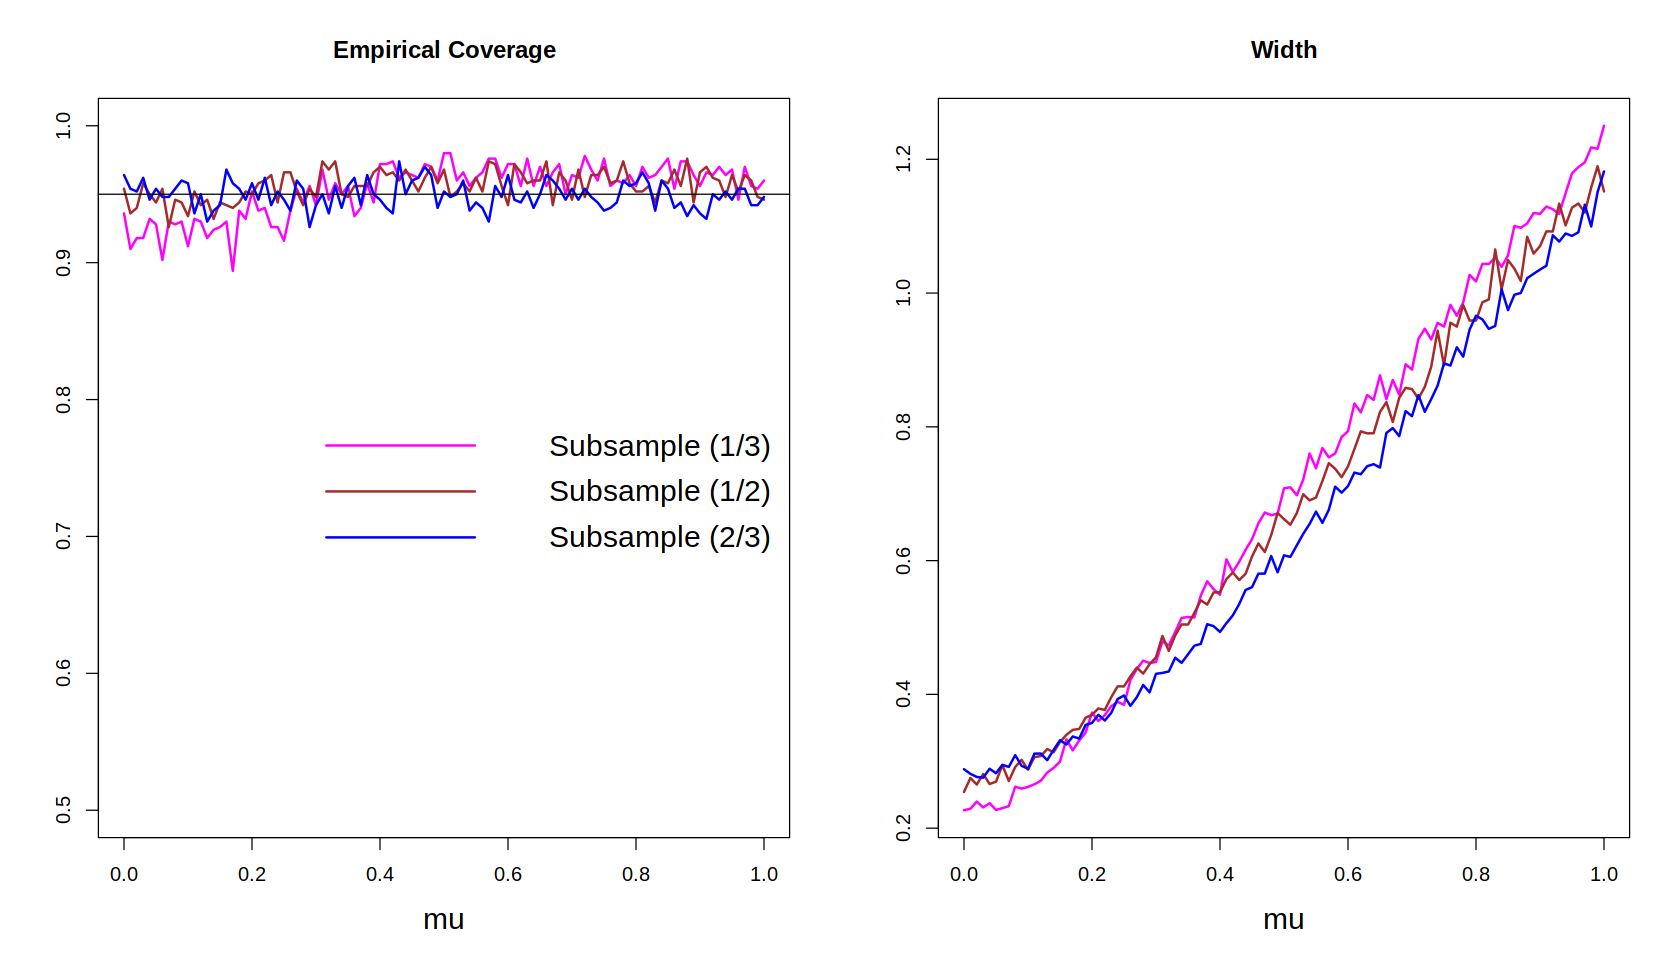

In [55]:
# options(repr.plot.width=14, repr.plot.height=8)
par(mfrow = c(1, 2))
dat1 <- subset(summary_mat, exponent == 1/3)
dat2 <- subset(summary_mat, exponent == 1/2)
dat3 <- subset(summary_mat, exponent == 2/3)
plot(dat1$mu, dat1$mean_coverage, ylim = c(0.5, 1), 
     type = 'l', xlab = "mu", col = "magenta",  ylab = "",
     lwd = 2, cex.lab = 1.5, main = "Empirical Coverage")
lines(dat2$mu, dat2$mean_coverage, col = "brown", lwd = 2)
lines(dat3$mu, dat3$mean_coverage, col = "blue", lwd = 2)
abline(h = 0.95)
legend(0.2, 0.8, legend=c("Subsample (1/3)", "Subsample (1/2)", "Subsample (2/3)"),
       col=c("magenta", "brown", "blue"), cex=1.5, lwd = 2, bty = 'n')
plot(dat1$mu, dat1$mean_width, type = 'l', xlab = "mu", ylab = "",
     col = "magenta", lwd = 2, cex.lab = 1.5, main = "Width")
lines(dat2$mu, dat2$mean_width, col = "brown", lwd = 2)
lines(dat3$mu, dat3$mean_width, col = "blue", lwd = 2)